# BPSK - Binary Phase Shift Keying

Let us first import the packages we will need.
We'll need NumPy for arrays, and square-root, amongst other.
And to plot the constellation we will need to import the matplotlib package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Mapping of bits to modulation coefficients
Below we create an array containging the constellation points. In BPSK the points lie on the real axis in -1 and +1.
Since indexing in python starts at 0, we will be smart here and let the position in the array correspond to the bit-values.

```python
# Here the index is 0; bin(0) = 0b0. Thus, the constellation point -1 corresponds to the bit 0.
bpsk_constellation[0] = complex(-1, 0)

# Here the index is 1; bin(1) = 0b1. Thus, the constellation point 1 corresponds to the bit 1.
bpsk_constellation[1] = complex(1, 0)
```

In [2]:
bpsk_constellation = np.array([complex(-1, 0), complex(1, 0)])

Next steps are to define how to modulate and demoudlate the symbols.
The modulation is easy; to map the bit 0 one just needs to read the complex value at position 0. And conversely for a bit value of 1.

In [3]:
def bpsk_modulation(bits):
    """
    
    :param bits: Integer representation of the bits to be modulated. For BPSK Integer and Binary are the same.
    :type bits: int
    :return: The complex constellation symbol
    :rtype: complex
    """
    try:
        return bpsk_constellation[bits]
    except IndexError:
        raise ValueError('{} is to large for this constellation.'.format(bin(bits)))

De-modulation is often harder. But with BPSK a straight-forward way is to check in which half-plane the symbols lie in the complex plane.

In [4]:
def bpsk_demodulation(received_symbol):
    """
    
    :param received_symbol: The complex symbol to be demodulated.
    :type received_symbol: complex
    :return: The demodulated bits, represented as the corresponding Integer value.
    :rtype: int
    """
    if received_symbol.real >= 0:
        return 1
    else:
        return 0

### Plotting the mapping
Below is a way to plot the constellation diagram. This is not restricted to BPSK. It will also plot the bits at each constellation point.

In [5]:
def plot_constellation(constellation, base=2):
    
    # Extract the x and y values for plotting
    in_phase = [symbol.real for symbol in constellation]
    quadrature = [symbol.imag for symbol in constellation]
    
    # The code word size, for BPSK: code_word_size k = 1
    # Constellation size: also called alphabet M = 2^k, 
    # where k is the number of bits in each symbol (code word size).
    code_word_size = int(np.log2(np.size(constellation)))

    # Plot the constellatoin points
    plt.figure()
    plt.plot(in_phase, quadrature, 'o')
    plt.title("Constellation diagram")
    plt.xlabel("In-phase")
    plt.ylabel("Quadrature")
    plt.grid(True)
    
    # The following snippet of code just adds strings to the plot
    # with the bits the symbol is representing
    count = 0
    for symbol in constellation:
        if base == 2:
            plt_str = '{0:0{1:d}b}'.format(count, int(code_word_size))
        if base == 10:
            plt_str = '{0:d}'.format(count)
        # x and y cordinates for the string are the real and imaginary parts of the symbol.
        plt.text(symbol.real, symbol.imag, plt_str)
        count += 1
        
    # Finally show the plot
    plt.show()

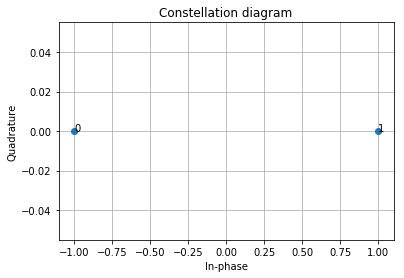

In [6]:
plot_constellation(bpsk_constellation)    

### Quick sanity check

In [7]:
tx_bits = np.random.randint(0, 2, 5)  # Create a vector with 1024 random bits to modulate
tx_symbols = np.array([bpsk_modulation(bit) for bit in tx_bits])  # Map the bits onto BPSK symbols

rx_bits = np.array([bpsk_demodulation(symbol) for symbol in tx_symbols])

all(rx_bits == tx_bits)  # Are all the received bits the same as the transmitted?

True

Now, the above example is not very intresting because there is no channel that corrupts or distorts the data. So, in the above tests just proves that the demodulation works as expected.

## Basis Pulses

In [8]:
from scipy.fftpack import fft, fftshift

In [9]:
T = 1.0    # Symbol duration

t = np.linspace(-15*T, 15*T, int(1.0e4))  # Time interval
g = [(1 if (0 <= t_i <= T) else 0) for t_i in t]  # Rectangular pulse, length T

f = fftshift(np.fft.fftfreq(len(t), t[1]-t[0]))
G_f = fftshift(fft(g)) * (T / len(t))

f_theo = np.linspace(-4, 4, int(1.0e3))
x = f_theo * T
G_f_theo = T * np.sinc(x) * np.exp(-1j * x)


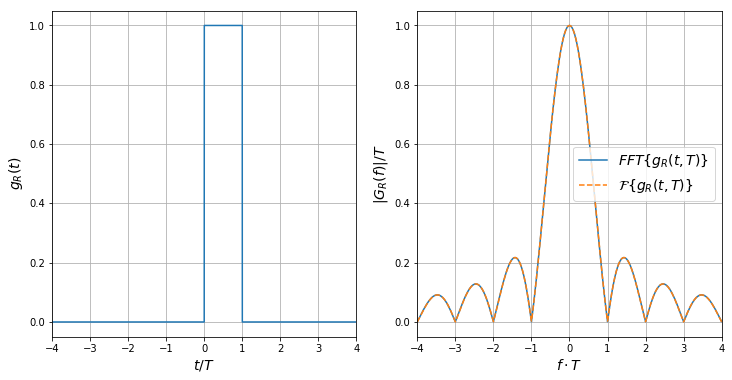

In [10]:
# Change size of plot
plt.rcParams['figure.figsize'] = [12, 6]

plt.figure()

# Plot the basis function
plt.subplot(1,2,1)
plt.plot(t/T, g)
plt.xlim(-4, 4)
plt.grid(True)
plt.xlabel(r'$t/T$', fontsize=14)
plt.ylabel(r'$g_R(t)$', fontsize=14)

# Plot the spectrum of the pulse
plt.subplot(1,2,2)
plt.plot(f * T, np.abs(G_f)/np.max(np.abs(G_f)), label=r'$FFT\{g_R(t, T)\}$')
plt.plot(f_theo * T, np.abs(G_f_theo)/T, '--', label=r'$\mathcal{F} \{g_R(t, T)\}$')
plt.xlim(-4, 4)
plt.grid(True)
plt.xlabel(r'$f\cdot T$', fontsize=14)
plt.ylabel(r'$|G_R(f)| / T$', fontsize=14)
plt.legend(prop={'size': 14})

plt.show()

## Power Spectrum / Occupied Bandwidth (11.2.3)

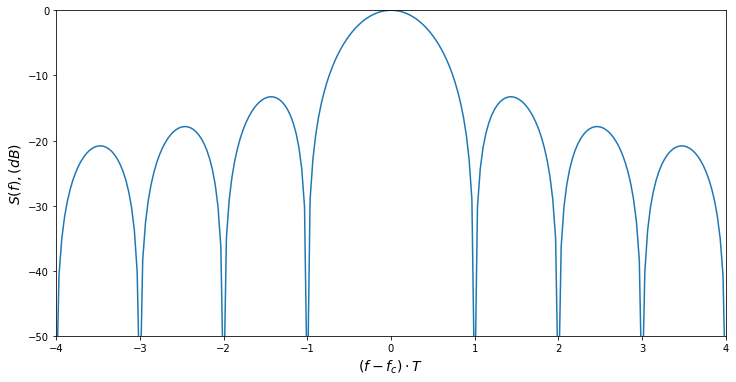

In [11]:
S_f = 20*np.log10(np.abs(G_f) * 1 / np.max(np.abs(G_f) * 1))

plt.figure()
plt.plot(f*T, S_f)
plt.xlim(-4, 4)
plt.ylim(-50, 0)
plt.xlabel(r'$(f-f_c)\cdot T$', fontsize=14)
plt.ylabel(r'$S(f), (dB)$', fontsize=14)
plt.show()

## Transmitted signal, Baseband -> Band-pass

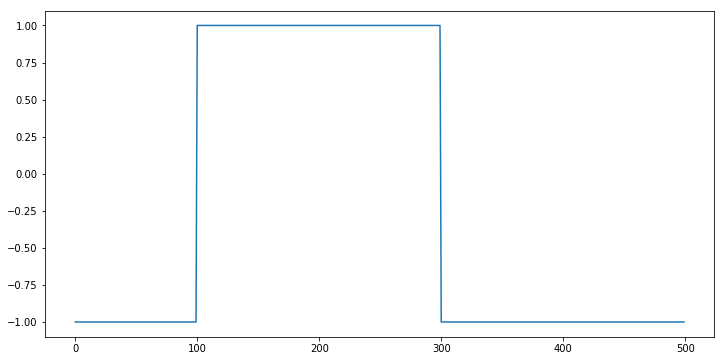

In [12]:
t = np.linspace(0, T, int(1.0e2))  # Time interval
g = [(1 if (0 <= t_i <= T) else 0) for t_i in t]  # Rectangular pulse, length T
s_bb = []
for symb in tx_symbols:
    a = np.convolve(symb, g)
    s_bb = np.hstack((s_bb, a))

plt.figure()
plt.plot(s_bb.real)

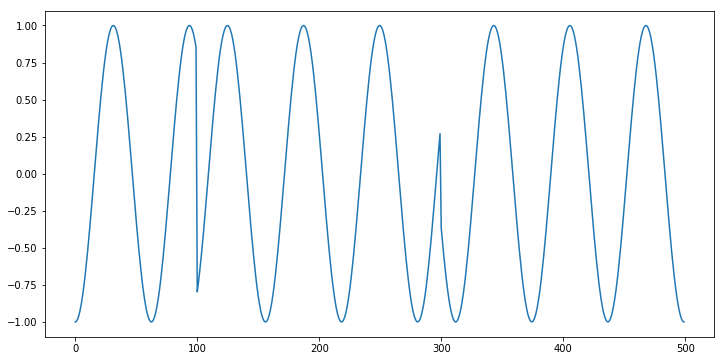

In [13]:
s_bp = s_bb*np.exp(1j*2*np.pi*1e9*np.linspace(0, len(tx_symbols)*len(t), int(len(tx_symbols)*1.0e2)))
plt.figure()
plt.plot(s_bp.real)